In [1]:
# PyTorch imports
import torch  # Main PyTorch library
import torch.nn as nn  # Neural network modules
import torch.optim as optim  # Optimization algorithms
#import torch.nn.functional as F  # Activation functions and other functional operations

import numpy as np # For matrix operations

# Data handling imports
from torch.utils.data import Dataset, DataLoader, random_split  # For dataset operations and data loading
from torchvision import datasets, transforms  # For vision datasets and image transformations

# Visualization and utility imports
import matplotlib.pyplot as plt  # For plotting graphs and images
import numpy as np  # For numerical operations
from tqdm import tqdm  # For progress bars in loops

/home/vgtu/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
# Custom dataset class
class MNISTWithParity(Dataset):
    def __init__(self, mnist_dataset):
        # Initialize the class with the original MNIST dataset
        self.mnist_dataset = mnist_dataset
    
    def __len__(self):
        # Return the length of the dataset
        return len(self.mnist_dataset)
    
    def __getitem__(self, idx):
        # Get an item from the dataset by index
        image, label = self.mnist_dataset[idx]
        
        # Calculate parity (odd/even) of the label
        parity = label % 2  # 0 for even, 1 for odd
        
        # Determine if label is less than 5 or not
        threshold = 0 if label < 5 else 1
        
        # Return the image, and a tuple containing the original label, its parity, and the threshold value
        return image, (label, parity, threshold)

In [ ]:
# ---------------- CHANGE: Improved CNN architecture ----------------
class DigitParityCNN(nn.Module):
    def __init__(self):
        super(DigitParityCNN, self).__init__()

        # Convolutional blocks
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),             # Added batchnorm
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),             # Added batchnorm
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),            # Added batchnorm
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        # Global Average Pooling instead of flatten
        self.gap = nn.AdaptiveAvgPool2d((1,1))

        # Fully connected layer with dropout
        self.fc = nn.Sequential(
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Dropout(0.3)                # < Added dropout
        )

        # Multi-task heads
        self.fc_digit = nn.Linear(128, 10)
        self.fc_parity = nn.Linear(128, 2)
        self.fc_threshold = nn.Linear(128, 2)

    def forward(self, x):
        x = self.features(x)
        x = self.gap(x)             # Added Global Average Pooling
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return self.fc_digit(x), self.fc_parity(x), self.fc_threshold(x)



In [4]:
# Hyperparameters
batch_size = 64        # Number of samples processed before the model is updated
learning_rate = 0.001  # Step size at each iteration while moving toward a minimum of the loss function
num_epochs = 10        # Number of complete passes through the training dataset
validation_split = 0.1 # Fraction of the training data to be used as validation data

In [5]:
# Data loading and preprocessing
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize((0.1307,), (0.3081,))  # Normalize with MNIST mean and std dev
])

In [6]:
# Load the MNIST dataset
mnist_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
# Create a custom dataset that includes parity information
custom_dataset = MNISTWithParity(mnist_dataset)

In [7]:
# Split dataset into training and validation sets
train_size = int((1 - validation_split) * len(custom_dataset))
val_size = len(custom_dataset) - train_size
train_dataset, val_dataset = random_split(custom_dataset, [train_size, val_size])

# Create data loaders for training and validation sets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [8]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the model and move it to the appropriate device (GPU or CPU)
model = DigitParityCNN().to(device)

In [ ]:
# Loss and optimizer setup

# Loss function for digit classification
criterion_digit = nn.CrossEntropyLoss()

# Loss function for parity classification
criterion_parity = nn.CrossEntropyLoss()

# Loss function for threshold classification
criterion_threshold = nn.CrossEntropyLoss()

# Adam optimizer for updating model parameters
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4) # Added weight decay = 1e-4

# Learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5) # Changed - step_size = 1 -> 5

Epoch [1/10], Train Loss: 0.5611, Val Loss: 0.2771
Train Digit Acc: 91.23%, Train Parity Acc: 96.28%, Train Threshold Acc: 94.56%
Val Digit Acc: 96.02%, Val Parity Acc: 98.67%, Val Threshold Acc: 95.92%


Epoch [2/10], Train Loss: 0.1356, Val Loss: 0.1090
Train Digit Acc: 98.18%, Train Parity Acc: 98.99%, Train Threshold Acc: 98.75%
Val Digit Acc: 98.48%, Val Parity Acc: 99.22%, Val Threshold Acc: 99.05%


Epoch [3/10], Train Loss: 0.0911, Val Loss: 0.1148
Train Digit Acc: 98.78%, Train Parity Acc: 99.35%, Train Threshold Acc: 99.16%
Val Digit Acc: 98.60%, Val Parity Acc: 98.98%, Val Threshold Acc: 98.75%


Epoch [4/10], Train Loss: 0.0691, Val Loss: 0.0800
Train Digit Acc: 99.10%, Train Parity Acc: 99.51%, Train Threshold Acc: 99.45%
Val Digit Acc: 99.02%, Val Parity Acc: 99.42%, Val Threshold Acc: 99.27%


Epoch [5/10], Train Loss: 0.0578, Val Loss: 0.0726
Train Digit Acc: 99.24%, Train Parity Acc: 99.64%, Train Threshold Acc: 99.49%
Val Digit Acc: 99.12%, Val Parity Acc: 99.33%, Val Threshold Acc: 99.42%


Epoch [6/10], Train Loss: 0.0509, Val Loss: 0.0704
Train Digit Acc: 99.32%, Train Parity Acc: 99.67%, Train Threshold Acc: 99.59%
Val Digit Acc: 99.10%, Val Parity Acc: 99.40%, Val Threshold Acc: 99.38%


Epoch [7/10], Train Loss: 0.0484, Val Loss: 0.0700
Train Digit Acc: 99.38%, Train Parity Acc: 99.73%, Train Threshold Acc: 99.59%
Val Digit Acc: 99.10%, Val Parity Acc: 99.42%, Val Threshold Acc: 99.40%


Epoch [8/10], Train Loss: 0.0466, Val Loss: 0.0696
Train Digit Acc: 99.40%, Train Parity Acc: 99.71%, Train Threshold Acc: 99.61%
Val Digit Acc: 99.05%, Val Parity Acc: 99.42%, Val Threshold Acc: 99.42%


Epoch [9/10], Train Loss: 0.0452, Val Loss: 0.0697
Train Digit Acc: 99.45%, Train Parity Acc: 99.73%, Train Threshold Acc: 99.61%
Val Digit Acc: 99.12%, Val Parity Acc: 99.42%, Val Threshold Acc: 99.40%


Epoch [10/10], Train Loss: 0.0450, Val Loss: 0.0701
Train Digit Acc: 99.41%, Train Parity Acc: 99.74%, Train Threshold Acc: 99.61%
Val Digit Acc: 99.10%, Val Parity Acc: 99.40%, Val Threshold Acc: 99.42%


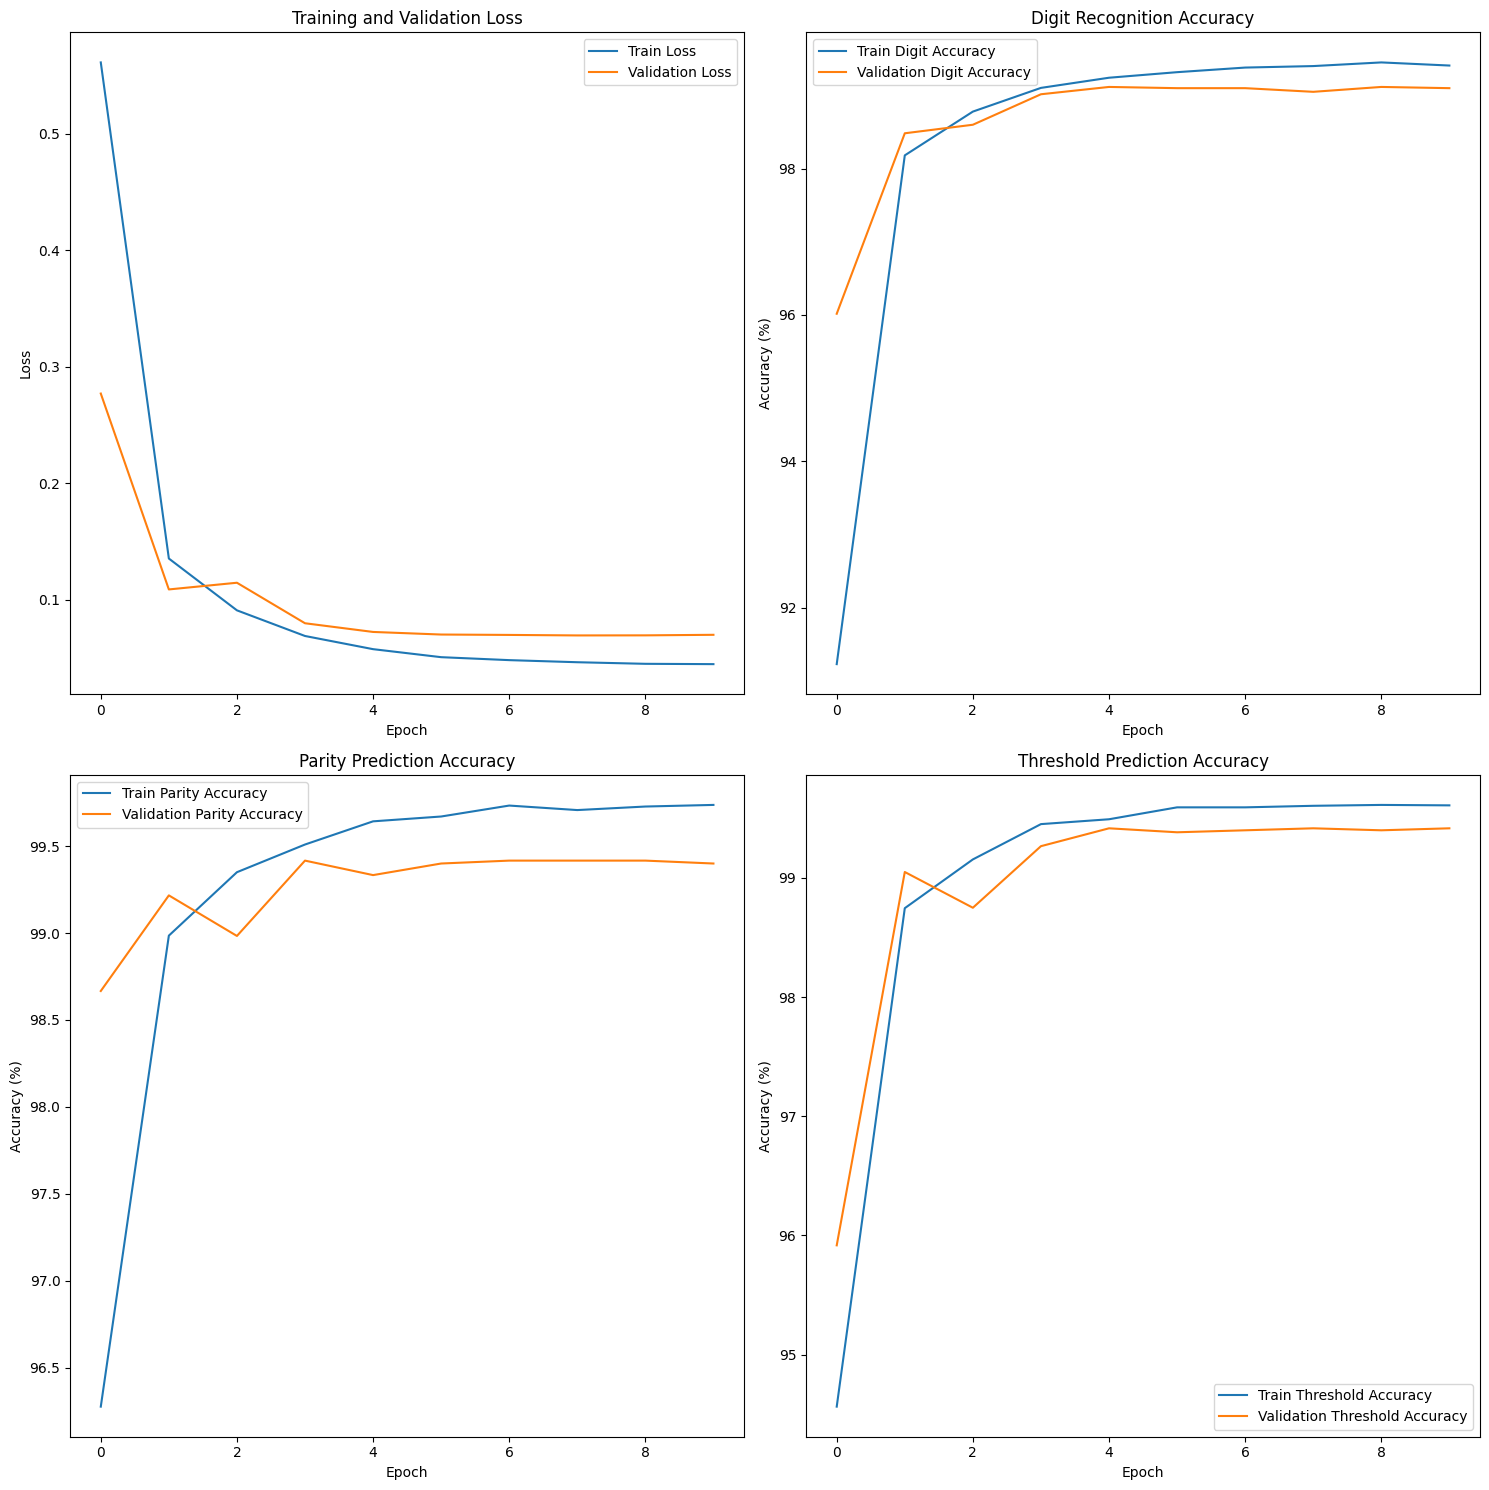

In [ ]:
# Initialize lists to store training and validation metrics
train_losses, val_losses = [], []
train_digit_accuracies, train_parity_accuracies, train_threshold_accuracies = [], [], []
val_digit_accuracies, val_parity_accuracies, val_threshold_accuracies = [], [], []

# Initialize variables for tracking the best model
best_val_loss = float('inf')
best_model_path = 'best_model_digit_parity_threshold.pth'

# Main training loop
for epoch in range(num_epochs):
    # Set model to training mode
    model.train()
    
    # Initialize metrics for this epoch
    running_loss = 0.0
    correct_digits, correct_parities, correct_thresholds, total = 0, 0, 0, 0
    
    # Create a progress bar for the training data
    train_loader_tqdm = tqdm(train_loader, desc=f'Epoch [{epoch+1}/{num_epochs}] - Training', leave=False, ascii=True)
    
    # Iterate over batches in the training data
    for images, (labels, parities, thresholds) in train_loader_tqdm:
        # Move the batch data to the appropriate device
        images, labels, parities, thresholds = images.to(device), labels.to(device), parities.to(device), thresholds.to(device)
        
        # Zero out the gradients
        optimizer.zero_grad()
        
        # Forward pass: compute the model output
        digit_outputs, parity_outputs, threshold_outputs = model(images)
        
        # Compute the loss
        loss_digit = criterion_digit(digit_outputs, labels)
        loss_parity = criterion_parity(parity_outputs, parities)
        loss_threshold = criterion_threshold(threshold_outputs, thresholds)
        loss = loss_digit + loss_parity + loss_threshold                     # Add multiplication with any number to increase the weight for each task.
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        # Accumulate the batch loss
        running_loss += loss.item()
        
        # Compute accuracies for this batch
        _, predicted_digits = torch.max(digit_outputs, 1)
        _, predicted_parities = torch.max(parity_outputs, 1)
        _, predicted_thresholds = torch.max(threshold_outputs, 1)
        total += labels.size(0)
        correct_digits += (predicted_digits == labels).sum().item()
        correct_parities += (predicted_parities == parities).sum().item()
        correct_thresholds += (predicted_thresholds == thresholds).sum().item()
        
        # Update the progress bar
        train_loader_tqdm.set_postfix({'Train Loss': f'{loss.item():8.4f}'})
    
    # Compute average loss and accuracies for this epoch
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)
    train_digit_accuracy = 100 * correct_digits / total
    train_parity_accuracy = 100 * correct_parities / total
    train_threshold_accuracy = 100 * correct_thresholds / total
    train_digit_accuracies.append(train_digit_accuracy)
    train_parity_accuracies.append(train_parity_accuracy)
    train_threshold_accuracies.append(train_threshold_accuracy)
    
    # Validation Phase
    model.eval()
    val_loss = 0.0
    correct_digits, correct_parities, correct_thresholds, total = 0, 0, 0, 0
    
    val_loader_tqdm = tqdm(val_loader, desc=f'Epoch [{epoch+1}/{num_epochs}] - Validation', leave=False, ascii=True)
    
    with torch.no_grad():
        for images, (labels, parities, thresholds) in val_loader_tqdm:
            images, labels, parities, thresholds = images.to(device), labels.to(device), parities.to(device), thresholds.to(device)
            
            digit_outputs, parity_outputs, threshold_outputs = model(images)
            
            loss_digit = criterion_digit(digit_outputs, labels)
            loss_parity = criterion_parity(parity_outputs, parities)
            loss_threshold = criterion_threshold(threshold_outputs, thresholds)
            loss = loss_digit + loss_parity + loss_threshold
            val_loss += loss.item()
            
            _, predicted_digits = torch.max(digit_outputs, 1)
            _, predicted_parities = torch.max(parity_outputs, 1)
            _, predicted_thresholds = torch.max(threshold_outputs, 1)
            total += labels.size(0)
            correct_digits += (predicted_digits == labels).sum().item()
            correct_parities += (predicted_parities == parities).sum().item()
            correct_thresholds += (predicted_thresholds == thresholds).sum().item()
            
            val_loader_tqdm.set_postfix({'Val Loss': f"{loss.item():8.4f}"})
    
    # Compute average validation loss and accuracies
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    val_digit_accuracy = 100 * correct_digits / total
    val_parity_accuracy = 100 * correct_parities / total
    val_threshold_accuracy = 100 * correct_thresholds / total
    val_digit_accuracies.append(val_digit_accuracy)
    val_parity_accuracies.append(val_parity_accuracy)
    val_threshold_accuracies.append(val_threshold_accuracy)
    
    # Print the results for this epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
    print(f'Train Digit Acc: {train_digit_accuracy:.2f}%, Train Parity Acc: {train_parity_accuracy:.2f}%, Train Threshold Acc: {train_threshold_accuracy:.2f}%')
    print(f'Val Digit Acc: {val_digit_accuracy:.2f}%, Val Parity Acc: {val_parity_accuracy:.2f}%, Val Threshold Acc: {val_threshold_accuracy:.2f}%')
    
    # Save the best model based on validation loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss,
            'best_val_loss': best_val_loss,
        }, best_model_path)
    
    # Step the learning rate scheduler
    scheduler.step()

# Visualization of training results
plt.figure(figsize=(15, 15))

# Plot 1: Training and Validation Loss
plt.subplot(2, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

# Plot 2: Digit Recognition Accuracy
plt.subplot(2, 2, 2)
plt.plot(train_digit_accuracies, label='Train Digit Accuracy')
plt.plot(val_digit_accuracies, label='Validation Digit Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Digit Recognition Accuracy')

# Plot 3: Parity Prediction Accuracy
plt.subplot(2, 2, 3)
plt.plot(train_parity_accuracies, label='Train Parity Accuracy')
plt.plot(val_parity_accuracies, label='Validation Parity Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Parity Prediction Accuracy')

# Plot 4: Threshold Prediction Accuracy
plt.subplot(2, 2, 4)
plt.plot(train_threshold_accuracies, label='Train Threshold Accuracy')
plt.plot(val_threshold_accuracies, label='Validation Threshold Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Threshold Prediction Accuracy')

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

In [11]:
# Load the best model for testing

# Load the MNIST test dataset
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Wrap the MNIST test dataset with our custom MNISTWithParity dataset
# This adds parity information to each sample
test_dataset = MNISTWithParity(test_dataset)

# Create a DataLoader for the test dataset
# We use shuffle=False for testing to maintain the original order of the dataset
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Load the saved checkpoint of the best model
# This checkpoint was saved during training when the model achieved the lowest validation loss
checkpoint = torch.load(best_model_path)

# Restore the model's state from the checkpoint
# This sets the model's parameters to the values that achieved the best validation performance
model.load_state_dict(checkpoint['model_state_dict'])

# Set the model to evaluation mode
# This disables dropout and sets batch normalization to use running statistics
model.eval()

DigitParityCNN(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (gap): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropo

In [12]:
def confusion_matrix(y_true, y_pred, num_classes):
    # Initialize a zero-filled matrix of size num_classes x num_classes
    # np.zeros creates a 2D array filled with zeros
    # The shape is (num_classes, num_classes)
    # dtype=int specifies that the array should contain integers
    cm = np.zeros((num_classes, num_classes), dtype=int)
    
    # Iterate through true and predicted labels simultaneously
    # zip(y_true, y_pred) pairs up corresponding elements from y_true and y_pred
    for true, pred in zip(y_true, y_pred):
        # Increment the count at the corresponding position in the matrix
        # true is used as the row index, pred as the column index
        # += 1 increments the count by 1 for each occurrence
        cm[true][pred] += 1
    
    # Return the completed confusion matrix
    # After all iterations, cm contains the counts of all (true, predicted) combinations
    return cm

In [13]:
def plot_confusion_matrix(cm, title, labels=None):
    # Create a new figure and axis with specified size
    fig, ax = plt.subplots(figsize=(6, 5))
    
    # Display the confusion matrix as an image
    # 'nearest' interpolation means no interpolation between pixels
    # plt.cm.Blues is a blue color map
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    
    # Add a colorbar to the plot, using the current axes
    ax.figure.colorbar(im, ax=ax)
    
    # Set various properties of the axis
    ax.set(
        xticks=np.arange(cm.shape[1]),  # Set x-axis ticks to match matrix columns
        yticks=np.arange(cm.shape[0]),  # Set y-axis ticks to match matrix rows
        title=title,  # Set the title of the plot
        ylabel='True label',  # Label for y-axis
        xlabel='Predicted label'  # Label for x-axis
    )
    
    # If labels are provided, use them for x and y axis
    if labels:
        ax.set_xticklabels(labels)  # Set labels for x-axis ticks
        ax.set_yticklabels(labels)  # Set labels for y-axis ticks
    
    # Rotate the tick labels on x-axis and set their alignment
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    
    # Calculate threshold for text color (white or black)
    # Values above thresh will be white, below will be black
    thresh = cm.max() / 2.
    
    # Add text annotations to each cell in the plot
    for i in range(cm.shape[0]):  # Iterate over rows
        for j in range(cm.shape[1]):  # Iterate over columns
            # Add text annotation for each cell
            ax.text(j, i, format(cm[i, j], 'd'),  # Position and value to display
                    ha="center", va="center",  # Center alignment
                    color="white" if cm[i, j] > thresh else "black")  # Choose text color based on cell value
    
    # Adjust the layout to prevent clipping of tick-labels
    fig.tight_layout()
    
    # Return the figure object
    return fig

In [14]:
def test_model(model, test_loader, device, criterion_digit, criterion_parity, criterion_threshold):
    model.eval()
    
    test_loss = 0.0
    correct_digit = 0
    correct_parity = 0
    correct_threshold = 0
    total = 0
    
    all_digit_preds = []
    all_digit_labels = []
    all_parity_preds = []
    all_parity_labels = []
    all_threshold_preds = []
    all_threshold_labels = []
    
    misclassified_images = []
    misclassified_labels = []
    misclassified_preds = []
    
    test_loader_tqdm = tqdm(test_loader, desc="Testing", leave=False, ascii=True)
    
    with torch.no_grad():
        for images, (labels, parities, thresholds) in test_loader_tqdm:
            images, labels, parities, thresholds = images.to(device), labels.to(device), parities.to(device), thresholds.to(device)
            
            digit_outputs, parity_outputs, threshold_outputs = model(images)
            
            loss_digit = criterion_digit(digit_outputs, labels)
            loss_parity = criterion_parity(parity_outputs, parities)
            loss_threshold = criterion_threshold(threshold_outputs, thresholds)
            loss = loss_digit + loss_parity + loss_threshold
            
            test_loss += loss.item()
            
            _, predicted_digit = torch.max(digit_outputs.data, 1)
            _, predicted_parity = torch.max(parity_outputs.data, 1)
            _, predicted_threshold = torch.max(threshold_outputs.data, 1)
            
            total += labels.size(0)
            correct_digit += (predicted_digit == labels).sum().item()
            correct_parity += (predicted_parity == parities).sum().item()
            correct_threshold += (predicted_threshold == thresholds).sum().item()
            
            all_digit_preds.extend(predicted_digit.cpu().numpy())
            all_digit_labels.extend(labels.cpu().numpy())
            all_parity_preds.extend(predicted_parity.cpu().numpy())
            all_parity_labels.extend(parities.cpu().numpy())
            all_threshold_preds.extend(predicted_threshold.cpu().numpy())
            all_threshold_labels.extend(thresholds.cpu().numpy())
            
            for i in range(len(labels)):
                if predicted_digit[i] != labels[i] or predicted_parity[i] != parities[i] or predicted_threshold[i] != thresholds[i]:
                    misclassified_images.append(images[i].cpu())
                    misclassified_labels.append((labels[i].cpu(), parities[i].cpu(), thresholds[i].cpu()))
                    misclassified_preds.append((predicted_digit[i].cpu(), predicted_parity[i].cpu(), predicted_threshold[i].cpu()))
    
    test_loss /= len(test_loader)
    accuracy_digit = 100 * correct_digit / total
    accuracy_parity = 100 * correct_parity / total
    accuracy_threshold = 100 * correct_threshold / total
    
    print(f'Test Loss: {test_loss:.4f}, Digit Accuracy: {accuracy_digit:.2f}%, Parity Accuracy: {accuracy_parity:.2f}%, Threshold Accuracy: {accuracy_threshold:.2f}%')
    
    cm_digit = confusion_matrix(all_digit_labels, all_digit_preds, num_classes=10)
    cm_parity = confusion_matrix(all_parity_labels, all_parity_preds, num_classes=2)
    cm_threshold = confusion_matrix(all_threshold_labels, all_threshold_preds, num_classes=2)
    
    plot_confusion_matrix(cm_digit, 'Digit Confusion Matrix', labels=range(10))
    plt.figure()
    plot_confusion_matrix(cm_parity, 'Parity Confusion Matrix', labels=['Even', 'Odd'])
    plt.figure()
    plot_confusion_matrix(cm_threshold, 'Threshold Confusion Matrix', labels=['<5', '>=5'])
    plt.show()
    
    return test_loss, accuracy_digit, accuracy_parity, accuracy_threshold, misclassified_images, misclassified_labels, misclassified_preds

Test Loss: 0.0654, Digit Accuracy: 99.09%, Parity Accuracy: 99.41%, Threshold Accuracy: 99.33%


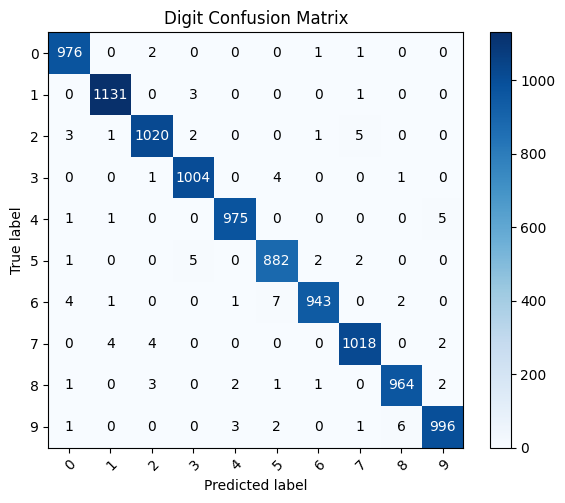

<Figure size 640x480 with 0 Axes>

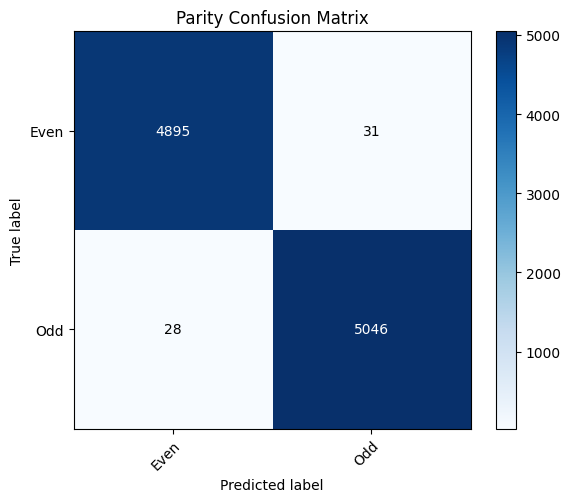

<Figure size 640x480 with 0 Axes>

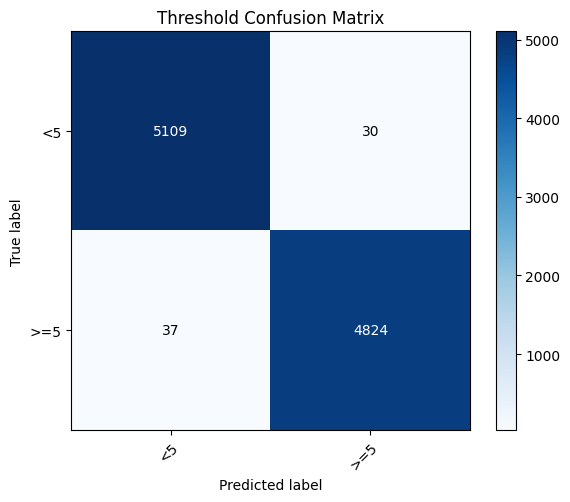

In [15]:
test_loss, accuracy_digit, accuracy_parity, accuracy_threshold, misclassified_images, misclassified_labels, misclassified_preds = test_model(model, test_loader, device, criterion_digit, criterion_parity, criterion_threshold)

In [16]:
# Function to display images
def imshow(img, title):
    img = img / 2 + 0.5
    
    # Convert the image tensor to a numpy array
    npimg = img.numpy()
    
    # Transpose the dimensions to match matplotlib's expected format
    # From (channels, height, width) to (height, width, channels)
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap='gray')
    
    # Set the title of the plot
    plt.title(title)
    
    # Display the image
    plt.show()

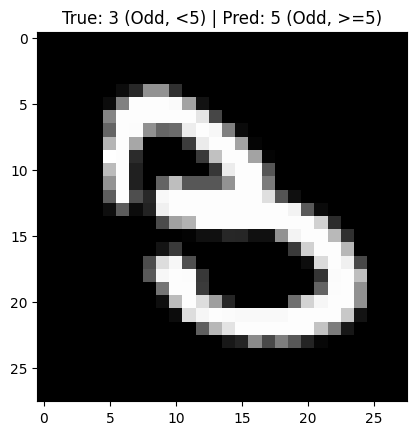

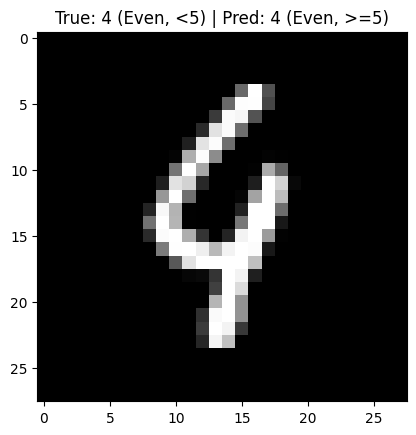

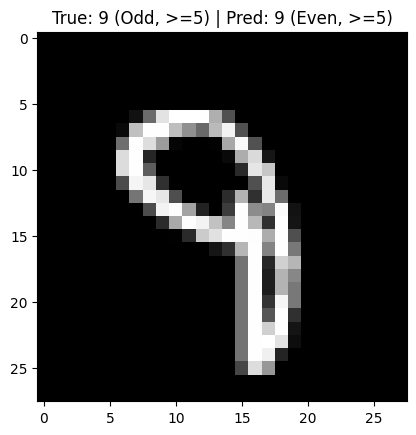

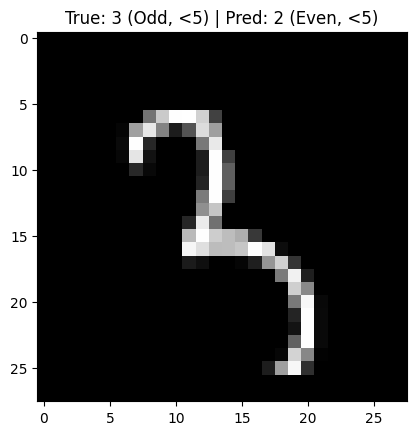

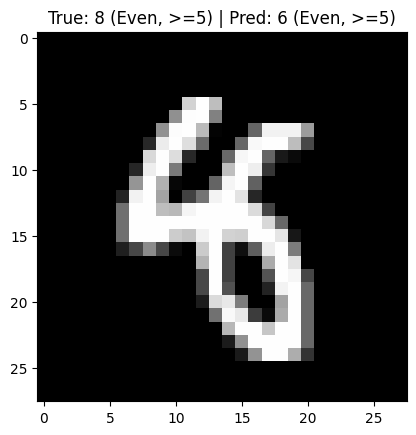

In [17]:
# Show a few misclassified images
for i in range(5):  # Loop through the first 5 misclassified images
    # Extract true labels, parities, and thresholds
    true_label, true_parity, true_threshold = misclassified_labels[i]
    
    # Extract predicted labels, parities, and thresholds
    pred_label, pred_parity, pred_threshold = misclassified_preds[i]
    
    # Create strings for true and predicted labels
    true_str = f'{true_label.item()} ({["Even", "Odd"][true_parity.item()]}, {["<5", ">=5"][true_threshold.item()]})'
    pred_str = f'{pred_label.item()} ({["Even", "Odd"][pred_parity.item()]}, {["<5", ">=5"][pred_threshold.item()]})'
    
    # Display the image using the custom imshow function
    imshow(misclassified_images[i],
           f'True: {true_str} | Pred: {pred_str}')